# Calculate WNPSH and EAJ subseasonal indices
This script is for calculation sub-seasonal Western North Pacific Subtropical height (WNPSH) and subseasonal East Asian westerl jet (EAJ).

In [1]:
import pandas as pd
import xarray as xr
import os
import numpy as np
import proplot as pplt

os.chdir('/Users/zeqinhuang/Documents/paper/anomalous_PREC')
to_dir = '/home/xtan/scratch/hzq/anomalous_PREC/proc_data'

/opt/anaconda3/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
def sel_domain(dataarray,lon_min,lon_max,lat_min,lat_max):
    mask_lon = (dataarray.lon >= lon_min) & (dataarray.lon <= lon_max)
    mask_lat = (dataarray.lat >= lat_min) & (dataarray.lat <= lat_max)
    dataarray = dataarray.where(mask_lon & mask_lat, drop=True)
    return dataarray

## calculate WNPSH index by Guan
* Sub-seasonal WNPSH definition (WeiNa Guan et al)
The subseasonal variations of the summer WPSH are measured by geopotential height anomalies at 500 hPa (Z500).
The subseasonal variability signals are obtained from the unfiltered daily time series by firstly taking a 5-day running mean after removal of the daily climatology, and then
subtracting the corresponding summer mean in each year to remove the interannual signals.
A local maximum Z500 variability center is noted over the domain (10–30°N, 110–140°E), which is defined as the core region in this study. A subseasonal
zonal variability index of the WPSH (hereafter the Sub-WPSH index) is then defined by the subseasonal JJA Z500 anomalies averaged over this core region.

In [3]:
wnpsh_lon_min = 110
wnpsh_lon_max = 140
wnpsh_lat_min = 10
wnpsh_lat_max = 30

In [4]:
gph_500 = xr.open_dataarray('dataset/era5/GPH_x40-160_y-20-60_t1961-2018_level500.nc')
gph_500 = gph_500.rename({'longitude':'lon','latitude':'lat'})
gph_500_base = gph_500.sel(time = slice('1961','1990'))
gph_500_clim = gph_500_base.groupby('time.dayofyear').mean()
gph_500_ano  = gph_500.groupby('time.dayofyear') - gph_500_clim # remove daily climatology
gph_500_ano  = gph_500_ano.rolling(time=5,center=True).mean() # 5 day rolling average
gph_500_ano  = gph_500_ano.sel(time = np.in1d(gph_500_ano['time.month'], [5,6,7,8,9,10])) # select summer period
wnpsh_500 = sel_domain(gph_500_ano, wnpsh_lon_min, wnpsh_lon_max, wnpsh_lat_min, wnpsh_lat_max) # select the core region of WNPSH

weights = np.cos(np.deg2rad(wnpsh_500.lat)) # area weight
weights.name = "weights"
wnpsh_500 = wnpsh_500.weighted(weights)
wnpsh_index = wnpsh_500.mean(("lon", "lat")) # area weight mean

/opt/anaconda3/lib/python3.8/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [5]:
wnpsh_index.to_pandas().to_csv('output/subseasonal_wnpsh_index_Guan.csv')

## calculate WNPSH index by Wang 
* Bin Wang et al, Interannual Variability of the Asian Summer Monsoon: Contrasts between the Indian and the Western North Pacific–East Asian Monsoons
* The dynamic monsoon index for the WNPSM (hereafter the WNP monsoon index or WNPMI) was defined, following Wang and Fan (1999), as the difference of 850-hPa westerlies between a southern region (5–15N, 100–130E) and a northern region (20–30N, 110-140E; Fig. 2). This latitudinal differential westerly index reflects not only the strength of the tropical westerlies but also the intensity of the low-level vorticity associated with the Rossby wave response to the Philippine Sea convective heat source.

In [6]:
domain1_lon_min = 110
domain1_lon_max = 140
domain1_lat_min = 20
domain1_lat_max = 30
domain2_lon_min = 100
domain2_lon_max = 130
domain2_lat_min = 5
domain2_lat_max = 15

In [7]:
uind_850 = xr.open_dataarray('dataset/era5/uwind_x40-160_y-20-60_t1961-2018_level850.nc')
uind_850 = uind_850.rename({'longitude':'lon','latitude':'lat'})
uind_850 = uind_850.rolling(time=5,center=True).mean() # 5 day rolling average
uind_850 = uind_850.sel(time = np.in1d(uind_850['time.month'], [5,6,7,8,9,10])) # select summer period
wnpsh_850 = uind_850
wnpsh_850_domain1 = sel_domain(wnpsh_850, domain1_lon_min, domain1_lon_max, domain1_lat_min, domain1_lat_max) # select the core region of WNPSH
wnpsh_850_domain2 = sel_domain(wnpsh_850, domain2_lon_min, domain2_lon_max, domain2_lat_min, domain2_lat_max) # select the core region of WNPSH

weights1 = np.cos(np.deg2rad(wnpsh_850_domain1.lat)) # area weight
weights2 = np.cos(np.deg2rad(wnpsh_850_domain2.lat)) # area weight
wnpsh_850_domain1 = wnpsh_850_domain1.weighted(weights1)
wnpsh_850_domain2 = wnpsh_850_domain2.weighted(weights2)
wnpsh_index = wnpsh_850_domain1.mean(("lon", "lat")) - wnpsh_850_domain2.mean(("lon", "lat"))

In [8]:
wnpsh_index.to_pandas().to_csv('output/subseasonal_wnpsh_index_Wang.csv')

## calculate WNPSH index by Wu
* Has the Western Pacific Subtropical High Extended Westward since the Late 1970s?
* The influence of the rising 500-hPa pressure level can be clearly demonstrated with the geopotential height relative to the global mean averaged over 0°–40°N (Fig. 3a). For clarity, we used the 8-gpm contour to represent the WPSH since it is close to the climatologic position of the 5870-gpm contour, which has been extensively used in previous studies. We use the band mean as a reference because the WPSH is identified at 500 hPa by comparing with the surrounding geopotential height. 
* The area mean value of the geopotential height at 500 hPa was calculated within the region 15°–30°N, 120°–140°E.

In [9]:
wnpsh_lon_min = 120
wnpsh_lon_max = 140
wnpsh_lat_min = 15
wnpsh_lat_max = 30

In [10]:
gph_500 = xr.open_dataarray('dataset/era5/GPH_x40-160_y-20-60_t_1961-2018_level500_eddy.nc')
gph_500 = gph_500.rename({'longitude':'lon','latitude':'lat'})
gph_500_base = gph_500.sel(time = slice('1961','1990'))
gph_500_clim = gph_500_base.groupby('time.dayofyear').mean()
gph_500_ano  = gph_500.groupby('time.dayofyear') - gph_500_clim # remove daily climatology
gph_500_ano  = gph_500_ano.rolling(time=5,center=True).mean() # 5 day rolling average
gph_500_ano  = gph_500_ano.sel(time = np.in1d(gph_500_ano['time.month'], [5,6,7,8,9,10])) # select summer period
wnpsh_500 = sel_domain(gph_500_ano, wnpsh_lon_min, wnpsh_lon_max, wnpsh_lat_min, wnpsh_lat_max) # select the core region of WNPSH

weights = np.cos(np.deg2rad(wnpsh_500.lat)) # area weight
weights.name = "weights"
wnpsh_500 = wnpsh_500.weighted(weights)
wnpsh_index = wnpsh_500.mean(("lon", "lat")) # area weight mean

In [11]:
wnpsh_index.to_pandas().to_csv('output/subseasonal_wnpsh_index_Wu.csv')

## calculate WNPSH index by LU
* Indices of the summertime western North Pacific subtropical high
* Geopotential heights at 850 hPa are used to depict the WNPSH.
* Zonal displacement of the WNPSH (110-150E,10-30N)
* Meridional displacement of the WNPSH (120-150E, 30-40N)

In [55]:
domain1_lon_min = 110
domain1_lon_max = 150
domain1_lat_min = 10
domain1_lat_max = 30

domain2_lon_min = 120
domain2_lon_max = 150
domain2_lat_min = 30
domain2_lat_max = 40

In [56]:
gph_500 = xr.open_dataarray('dataset/era5/GPH_x40-160_y-20-60_t1961-2018_level500.nc')
gph_500 = gph_500.rename({'longitude':'lon','latitude':'lat'})
gph_500_base = gph_500.sel(time = slice('1961','1990'))
gph_500_clim = gph_500_base.groupby('time.dayofyear').mean()
gph_500_ano  = gph_500.groupby('time.dayofyear') - gph_500_clim # remove daily climatology
gph_500_ano  = gph_500_ano.rolling(time=5,center=True).mean() # 5 day rolling average
gph_500_ano  = gph_500_ano.sel(time = np.in1d(gph_500_ano['time.month'], [5,6,7,8,9,10])) # select summer period
wnpsh_500 = sel_domain(gph_500_ano, domain1_lon_min, domain1_lon_max, domain1_lat_min, domain1_lat_max) # select the core region of WNPSH

weights = np.cos(np.deg2rad(wnpsh_500.lat)) # area weight
weights.name = "weights"
wnpsh_500 = wnpsh_500.weighted(weights)
wnpsh_index = wnpsh_500.mean(("lon", "lat")) # area weight mean

wnpsh_index.to_pandas().to_csv('output/subseasonal_wnpsh_index_LU_zonal.csv')

In [14]:
gph_500 = xr.open_dataarray('dataset/era5/GPH_x40-160_y-20-60_t1961-2018_level500.nc')
gph_500 = gph_500.rename({'longitude':'lon','latitude':'lat'})
gph_500_base = gph_500.sel(time = slice('1961','1990'))
gph_500_clim = gph_500_base.groupby('time.dayofyear').mean()
gph_500_ano  = gph_500.groupby('time.dayofyear') - gph_500_clim # remove daily climatology
gph_500_ano  = gph_500_ano.rolling(time=5,center=True).mean() # 5 day rolling average
gph_500_ano  = gph_500_ano.sel(time = np.in1d(gph_500_ano['time.month'], [5,6,7,8,9,10])) # select summer period
wnpsh_500 = sel_domain(gph_500_ano, domain2_lon_min, domain2_lon_max, domain2_lat_min, domain2_lat_max) # select the core region of WNPSH

weights = np.cos(np.deg2rad(wnpsh_500.lat)) # area weight
weights.name = "weights"
wnpsh_500 = wnpsh_500.weighted(weights)
wnpsh_index = wnpsh_500.mean(("lon", "lat")) # area weight mean

wnpsh_index.to_pandas().to_csv('output/subseasonal_wnpsh_index_LU_meridional.csv')

## calculate EAJ index by LU
* Lu Riyu 2004. Associations among the components of the East Asian summer monsoon system in the meridional direction.
* The EAJ index (EAJI), which is used to measure the meridional displacement of the EAJ, 
is defined as the difference in the area-averaged JJA-mean 200-hPa zonal winds between (30°–40°N, 120°–150°E) and (40°–50°N, 120°–150°E) , 
which are located to the south and north of the climatological jet axis, respectively. 
The subseasonal variability signals are processed similar with the sub-seasonal WNPSH.

In [15]:
eaj1_lon_min = 120
eaj1_lon_max = 150
eaj1_lat_min = 30
eaj1_lat_max = 40

eaj2_lon_min = 120
eaj2_lon_max = 150
eaj2_lat_min = 40
eaj2_lat_max = 50

In [16]:
uwind_200 = xr.open_dataarray('dataset/era5/uwind_x40-160_y-20-60_t1961-2018_level200.nc')
uwind_200 = uwind_200.rename({'longitude':'lon','latitude':'lat'})

eaj1_uwind = sel_domain(uwind_200, eaj1_lon_min, eaj1_lon_max, eaj1_lat_min, eaj1_lat_max)
eaj2_uwind = sel_domain(uwind_200, eaj2_lon_min, eaj2_lon_max, eaj2_lat_min, eaj2_lat_max)

weights1 = np.cos(np.deg2rad(eaj1_uwind.lat)) # area weight
weights2 = np.cos(np.deg2rad(eaj2_uwind.lat)) # area weight
eaj1 = eaj1_uwind.weighted(weights1).mean(('lon','lat'))
eaj2 = eaj2_uwind.weighted(weights2).mean(('lon','lat'))
eaj_index = eaj1 - eaj2

eaj_index  = eaj_index.sel(time = np.in1d(eaj_index['time.month'], [5,6,7,8,9,10])) # select summer period

In [17]:
eaj_index.to_pandas().to_csv('output/subseasonal_eaj_index_LU.csv')

## calculate EAJ index by XUAN
* Anomalous Midsummer Rainfall in Yangtze River-Huaihe River Valleys and Its Association with the East Asia Westerly Jet
* Considering the climatic position of the EAWJ axis in July (near 40◦N), the EAWJPI was defined as the difference (southward minus northward) between 200-hPa zonal wind averaged over two regions: 35◦–40◦N, 90◦–130◦E and 40◦–45◦N, 90◦–130◦E. Positive values indicate the southward displacement of the EAWJ; negative values indicate the northward displacement of the EAWJ.

In [18]:
# eaj1_lon_min = 90
# eaj1_lon_max = 130
# eaj1_lat_min = 35
# eaj1_lat_max = 40

# eaj2_lon_min = 90
# eaj2_lon_max = 130
# eaj2_lat_min = 40
# eaj2_lat_max = 45

In [89]:
# uwind_200 = xr.open_dataarray('dataset/era5/uwind_x40-160_y-20-60_t1961-2018_level200.nc')
# uwind_200 = uwind_200.rename({'longitude':'lon','latitude':'lat'})

# eaj1_uwind = sel_domain(uwind_200, eaj1_lon_min, eaj1_lon_max, eaj1_lat_min, eaj1_lat_max)
# eaj2_uwind = sel_domain(uwind_200, eaj2_lon_min, eaj2_lon_max, eaj2_lat_min, eaj2_lat_max)

# weights1 = np.cos(np.deg2rad(eaj1_uwind.lat)) # area weight
# weights2 = np.cos(np.deg2rad(eaj2_uwind.lat)) # area weight
# eaj1 = eaj1_uwind.weighted(weights1).mean(('lon','lat'))
# eaj2 = eaj2_uwind.weighted(weights2).mean(('lon','lat'))
# eaj_index = eaj1 - eaj2

# # eaj_index_base = eaj_index.sel(time = slice('1961','1990'))
# # eaj_index_clim = eaj_index_base.groupby('time.dayofyear').mean()
# # eaj_index_ano  = eaj_index.groupby('time.dayofyear') - eaj_index_clim # remove daily climatology
# # eaj_index  = eaj_index_ano.rolling(time=5,center=True).mean() # 5 day rolling average
# eaj_index  = eaj_index.sel(time = np.in1d(eaj_index['time.month'], [5,6,7,8,9,10])) # select summer period
# # eaj_index = eaj_index.groupby('time.year') - eaj_index.groupby('time.year').mean()    # remove the interannual signal
# eaj_index.to_pandas().to_csv('output/subseasonal_eaj_index_Xuan.csv')

## calculate EAJ index by Li
* Effects of Different Configurations of the East Asian Subtropical and Polar Front Jets on Precipitation during the Mei-Yu Season
* The jet intensity indices are calculated according to the wind speed over the key areas 
* Based on wind speed and jet center occurrence numbers, the region over 35°–40°N, 100°–140°E is identified as the key area for EASJ. The daily area average wind speeds at 300 hPa over the key areas are defined as the daily intensity indices for EASJ. The standardized index EASJ is used to evaluate the intensity and variation of the jets. Index EASJ used hereafter is standardized values.

In [140]:
eaj_lon_min = 100
eaj_lon_max = 140
eaj_lat_min = 35
eaj_lat_max = 40

In [141]:
uvwind_300 = xr.open_dataarray('dataset/era5/uvwind_x40-160_y-20-60_t1961-2018_level300.nc')
uvwind_300 = uvwind_300.rename({'longitude':'lon','latitude':'lat'})

eaj_uvwind = sel_domain(uvwind_300, eaj_lon_min, eaj_lon_max, eaj_lat_min, eaj_lat_max)

weights = np.cos(np.deg2rad(eaj_uvwind.lat)) # area weight
eaj_index = eaj_uvwind.weighted(weights).mean(('lon','lat'))

# eaj_index_base = eaj_index.sel(time = slice('1961','1990'))
# eaj_index_clim = eaj_index_base.groupby('time.dayofyear').mean()
# eaj_index_ano  = eaj_index.groupby('time.dayofyear') - eaj_index_clim # remove daily climatology
# eaj_index  = eaj_index_ano.rolling(time=5,center=True).mean() # 5 day rolling average
eaj_index  = eaj_index.sel(time = np.in1d(eaj_index['time.month'], [5,6,7,8,9,10])) # select summer period
# eaj_index = eaj_index.groupby('time.year') - eaj_index.groupby('time.year').mean()    # remove the interannual signal
eaj_index.to_pandas().to_csv('output/subseasonal_eaj_index_Li.csv')

# Comparing different indices

In [84]:
wnpsh_index_Guan = pd.read_csv('output/subseasonal_wnpsh_index_Guan.csv',index_col=0)
wnpsh_index_Wang = pd.read_csv('output/subseasonal_wnpsh_index_Wang.csv',index_col=0)
wnpsh_index_Wu = pd.read_csv('output/subseasonal_wnpsh_index_Wu.csv',index_col=0)
wnpsh_index_LU_zonal = pd.read_csv('output/subseasonal_wnpsh_index_LU_zonal.csv',index_col=0)
wnpsh_index_LU_meridional = pd.read_csv('output/subseasonal_wnpsh_index_LU_meridional.csv',index_col=0)
wnpsh_indices = pd.DataFrame(
    {'WNPSH_Guan':wnpsh_index_Guan['0'],'WNPSH_Wang':wnpsh_index_Wang['0'],
    'WNPSH_Wu':wnpsh_index_Wu['0'],'WNPSH_Lu':wnpsh_index_LU_zonal['0'],
    }) #'WNPSH_Lu2':wnpsh_index_LU_meridional['0']

wnpsh_indices = wnpsh_indices.apply(lambda x: (x - x.mean()) / x.std(), axis = 0)

In [142]:
eaj_index_Xuan = pd.read_csv('output/subseasonal_eaj_index_Xuan.csv',index_col=0)
eaj_index_Lu = pd.read_csv('output/subseasonal_eaj_index_LU.csv',index_col=0)
eaj_index_Li = pd.read_csv('output/subseasonal_eaj_index_Li.csv',index_col=0)
eaj_indices = pd.DataFrame(
    {'EAJ_Xuan':eaj_index_Xuan['0'],'EAJ_Lu':eaj_index_Lu['0'],'EAJ_Li':eaj_index_Li['0']})

eaj_indices = eaj_indices.apply(lambda x: (x - x.mean()) / x.std(), axis = 0)

In [63]:
winner_obs = pd.read_csv('output/winner_obs.csv',index_col=0)
winner = pd.Series(winner_obs['0'])
winner.name = 'SOM_pattern'

In [85]:
wnpsh_index_prec = wnpsh_indices.loc[winner.index]
corr = wnpsh_index_prec.corr()
corr.style.background_gradient(cmap='coolwarm')

,WNPSH_Guan,WNPSH_Wang,WNPSH_Wu,WNPSH_Lu
WNPSH_Guan,1.000000,0.527018,0.785040,0.985821
WNPSH_Wang,0.527018,1.000000,0.454816,0.474795
WNPSH_Wu,0.785040,0.454816,1.000000,0.762623
WNPSH_Lu,0.985821,0.474795,0.762623,1.000000


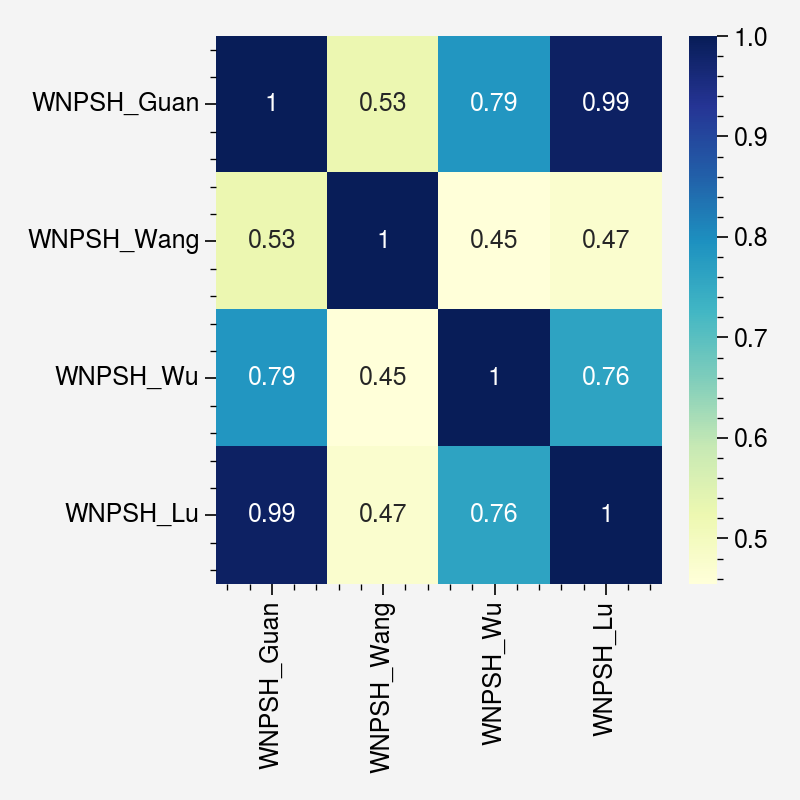

In [86]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
dataplot = sb.heatmap(corr, cmap="YlGnBu", annot=True)
plt.tight_layout()

<AxesSubplot:>

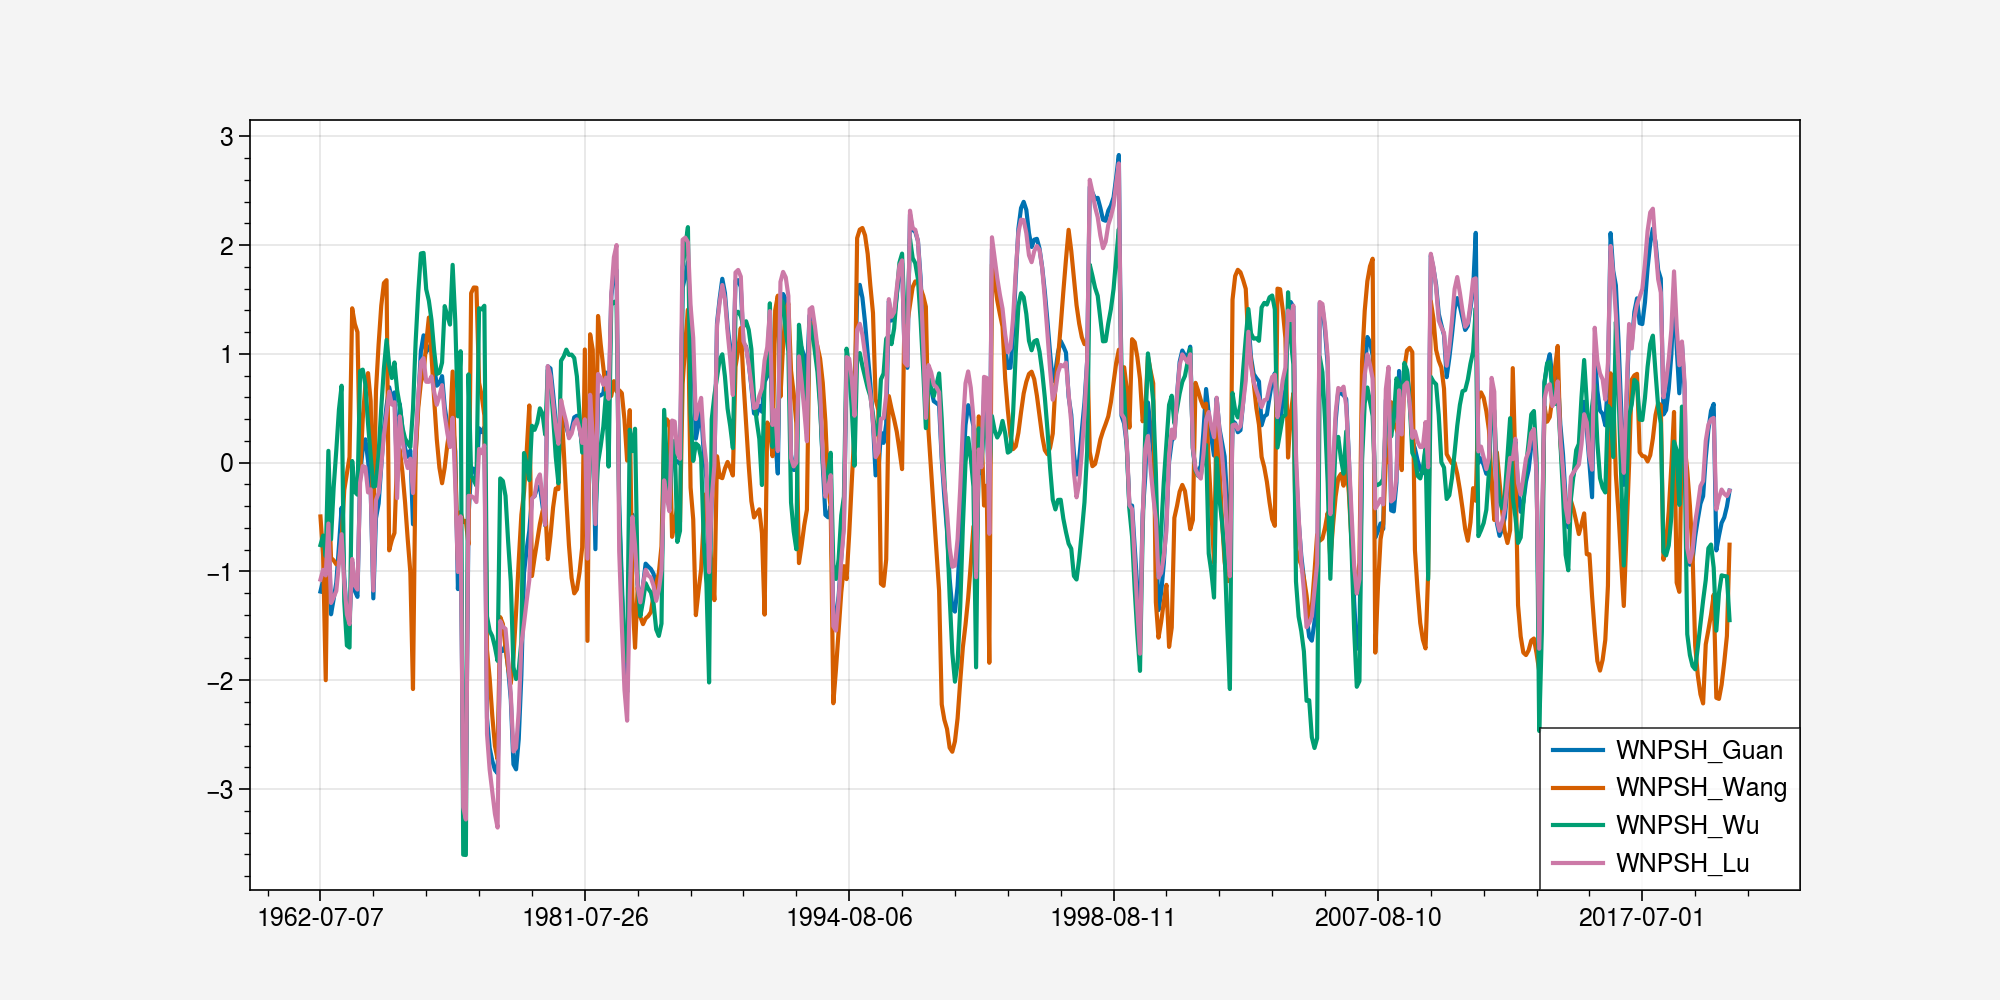

In [94]:
wnpsh_index_prec.plot(figsize=(10,5))

In [161]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr

class Pairs(object):
    def __init__(self, pdata: pd.DataFrame,
                 title: str = 'Here is the title',
                 figsize: tuple = (10, 5),
                 dpi: int = 100):

        if not isinstance(pdata, pd.DataFrame):
            raise ValueError("data must be a pd.DataFrame")

        pdata = pdata.select_dtypes(include=np.number)
        if pdata.shape[1] < 2:
            raise ValueError("data至少要有2列是数值型")

        self.figsize = figsize
        self.dpi = dpi
        self.title = title

        self.rawdata = pdata
        self.num_rol = self.rawdata.shape[1]
        self.data_col_name = self.rawdata.columns.tolist()

        self.cor_bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
        self.title_bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.2)

    def pairs(self):
        fig, ax = plt.subplots(ncols=self.num_rol,
                               nrows=self.num_rol,
                               figsize=self.figsize,
                               dpi=self.dpi)

        for temp_col in range(self.num_rol):
            for temp_row in range(self.num_rol):

                if temp_row == temp_col:
                    # plot 主对角线
                    sns.histplot(data=self.rawdata,
                                 x=self.data_col_name[temp_col],
                                 bins=10,alpha=1,
                                 ax=ax[temp_row, temp_col])
                    ax[temp_row, temp_col].set(xlabel=None)
                    ax[temp_row, temp_col].set(ylabel=None)
                    ax[temp_row, temp_col].annotate(self.data_col_name[temp_col],
                                                    xy=(0.5, 0.85),
                                                    size=8,
                                                    color = 'red',
                                                    ha='center',
                                                    bbox=self.title_bbox_props,
                                                    xycoords="axes fraction")
                    ax[temp_row, temp_col].grid(axis='x')
                    ax[temp_row, temp_col].tick_params(axis='both', which='major', labelsize=6.5)
                elif temp_row > temp_col:
                    # 下对角线
                    ax[temp_row, temp_col].grid(False)
                    sns.scatterplot(data=self.rawdata,
                                    x=self.data_col_name[temp_col],
                                    y=self.data_col_name[temp_row],
                                    color='black',
                                    s = 5,
                                    ax=ax[temp_row, temp_col])
                    # ax[temp_row, temp_col].set_yticks([])
                    ax[temp_row, temp_col].set(xlabel=None)
                    ax[temp_row, temp_col].set(ylabel=None)
                    ax[temp_row, temp_col].tick_params(axis='both', which='major', labelsize=5)

                elif temp_row < temp_col:
                    # 上对角线
                    ax[temp_row, temp_col].axis([0, 1, 0, 1])
                    cor_value, p_value = pearsonr(x=self.rawdata[self.data_col_name[temp_col]],
                                                  y=self.rawdata[self.data_col_name[temp_row]])
                    cor_value = np.around(cor_value, 5)
                    # 0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
                    if 0 <= p_value < 0.001:
                        show_p_value = "***"
                    elif 0.001 <= p_value < 0.01:
                        show_p_value = "**"
                    elif 0.01 <= p_value < 0.05:
                        show_p_value = "*"
                    elif 0.05 <= p_value < 0.1:
                        show_p_value = "."
                    elif 0.1 <= p_value <= 1:
                        show_p_value = " "
                    else:
                        show_p_value = " "

                    ax[temp_row, temp_col].text(0.5, 0.5, f"{cor_value:.2f}",ha='center',) # bbox=self.cor_bbox_props
                    ax[temp_row, temp_col].text(0.5, 0.3, f"{show_p_value:^3}", color='red',ha='center',
                                                ) #bbox=self.cor_bbox_props
                    ax[temp_row, temp_col].set_xticks([])
                    ax[temp_row, temp_col].set_yticks([])
                    ax[temp_row, temp_col].tick_params(axis='both', which='major', labelsize=5)

                # remove duplicates xticks and xlabel
                if temp_row != self.num_rol - 1:
                    ax[temp_row, temp_col].set_xticks([])
                    ax[temp_row, temp_col].set(xlabel=None)

                if temp_row > temp_col and temp_col != 0:
                    ax[temp_row, temp_col].set(ylabel=None)
                    ax[temp_row, temp_col].set_yticks([])
        fig.suptitle(self.title)
        fig.tight_layout()
        return fig, ax

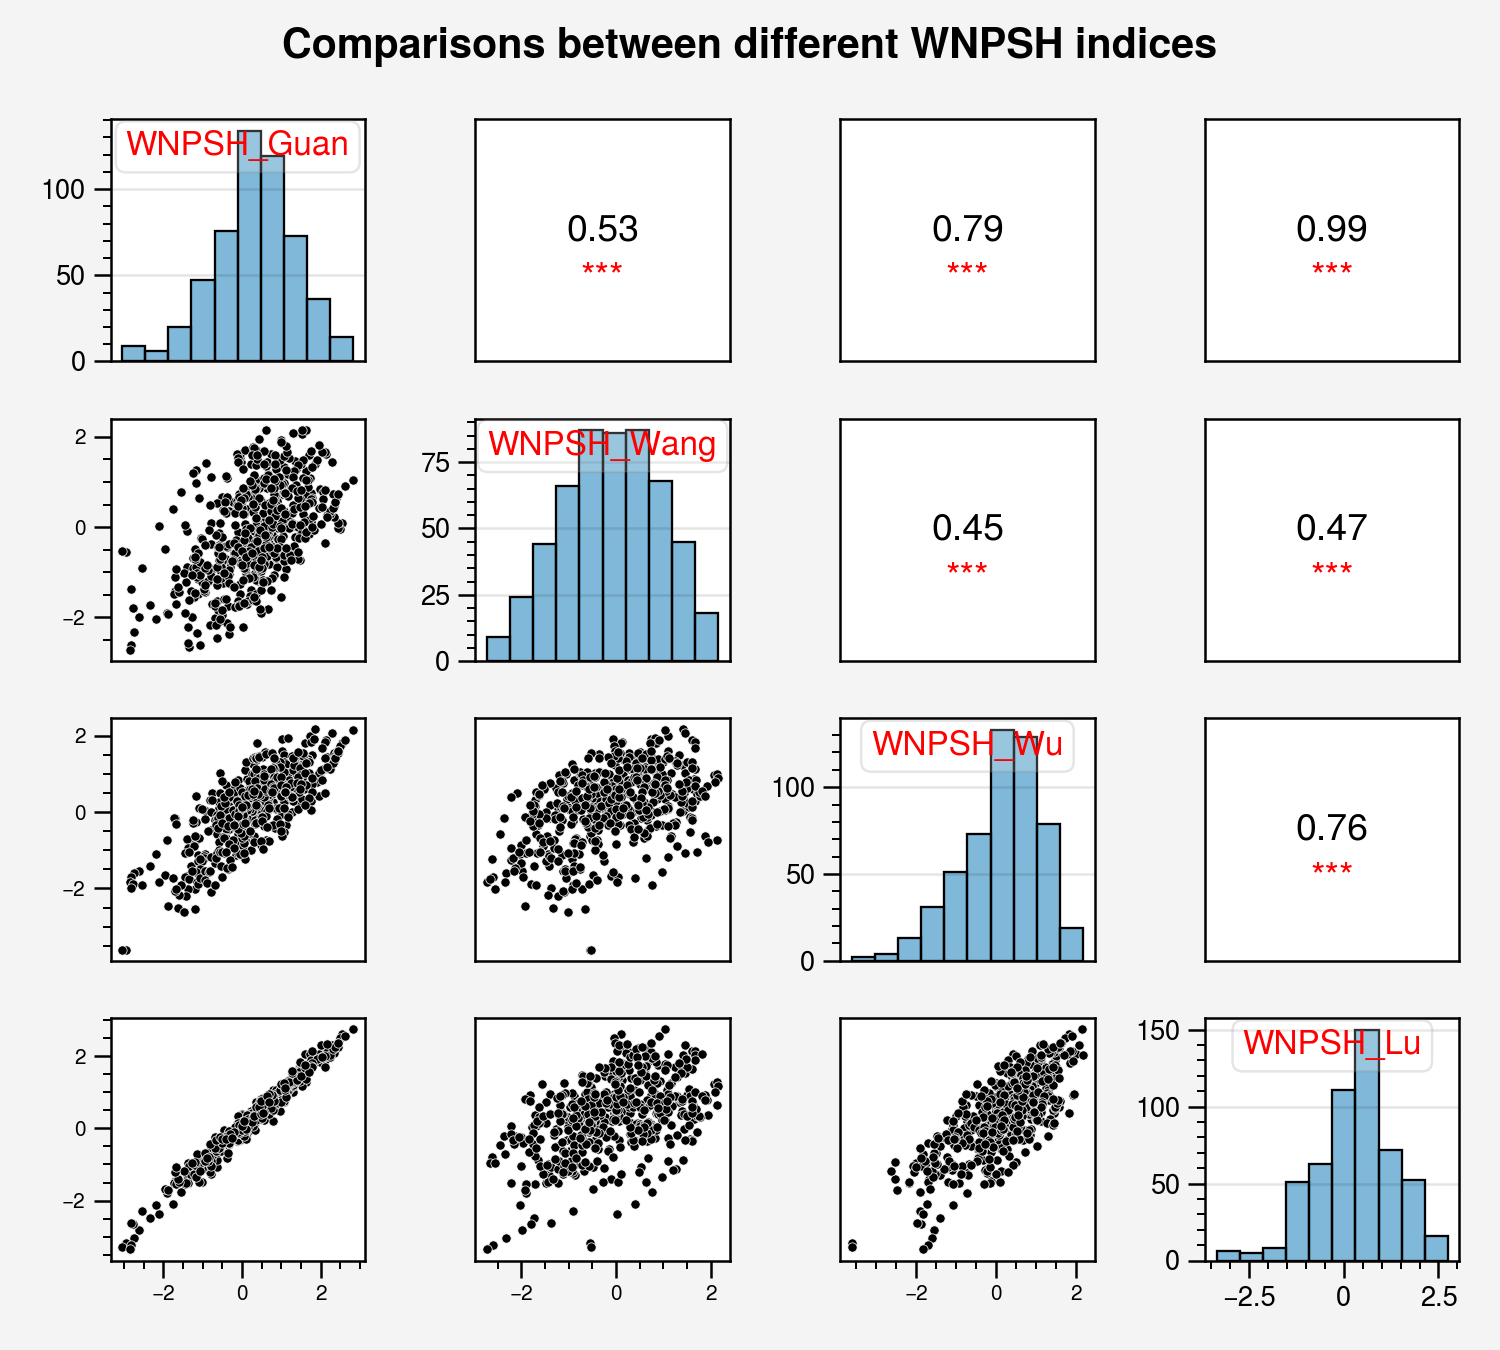

In [162]:
p = Pairs(pdata=wnpsh_index_prec, figsize=(5, 4.5), dpi=150,title='Comparisons between different WNPSH indices')
fig, ax = p.pairs()
plt.savefig("figure/compare_WNPSH.pdf")

In [143]:
eaj_index_prec = eaj_indices.loc[winner.index]
corr = eaj_index_prec.corr()
corr.style.background_gradient(cmap='coolwarm')

,EAJ_Xuan,EAJ_Lu,EAJ_Li
EAJ_Xuan,1.000000,0.664072,0.688563
EAJ_Lu,0.664072,1.000000,0.545590
EAJ_Li,0.688563,0.545590,1.000000


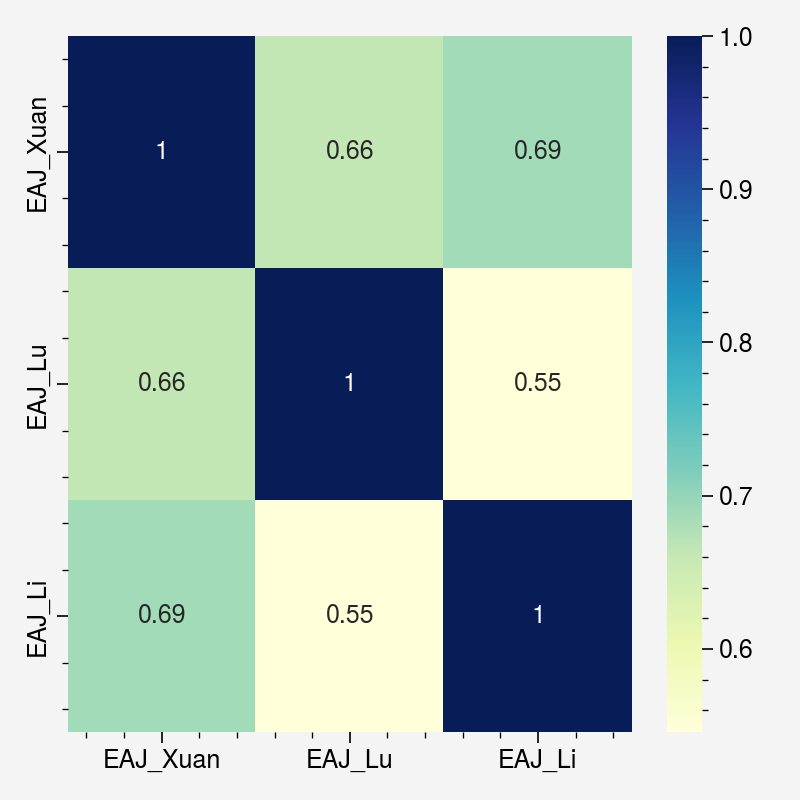

In [144]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
dataplot = sb.heatmap(corr, cmap="YlGnBu", annot=True)
plt.tight_layout()

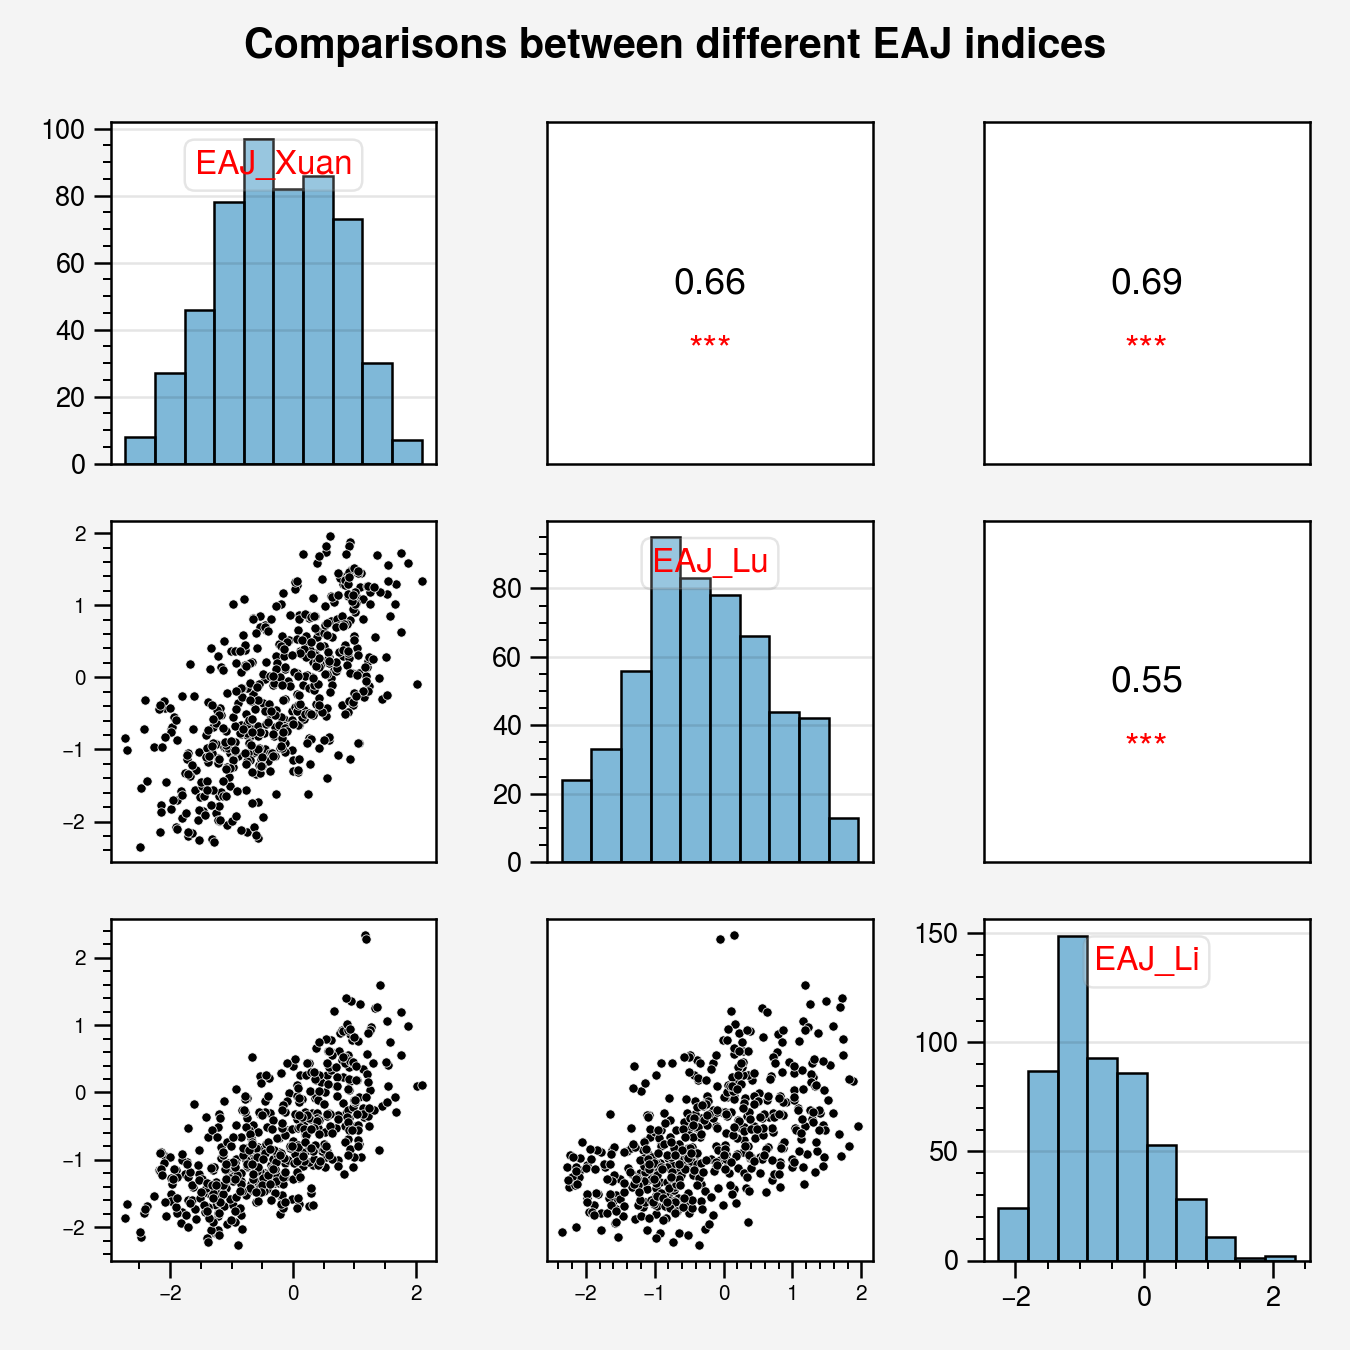

In [165]:
p = Pairs(pdata=eaj_index_prec, figsize=(4.5, 4.5), dpi=150,title='Comparisons between different EAJ indices')
fig, ax = p.pairs()
plt.savefig("figure/compare_EAJ.pdf")

# Comparing different indices for different patterns

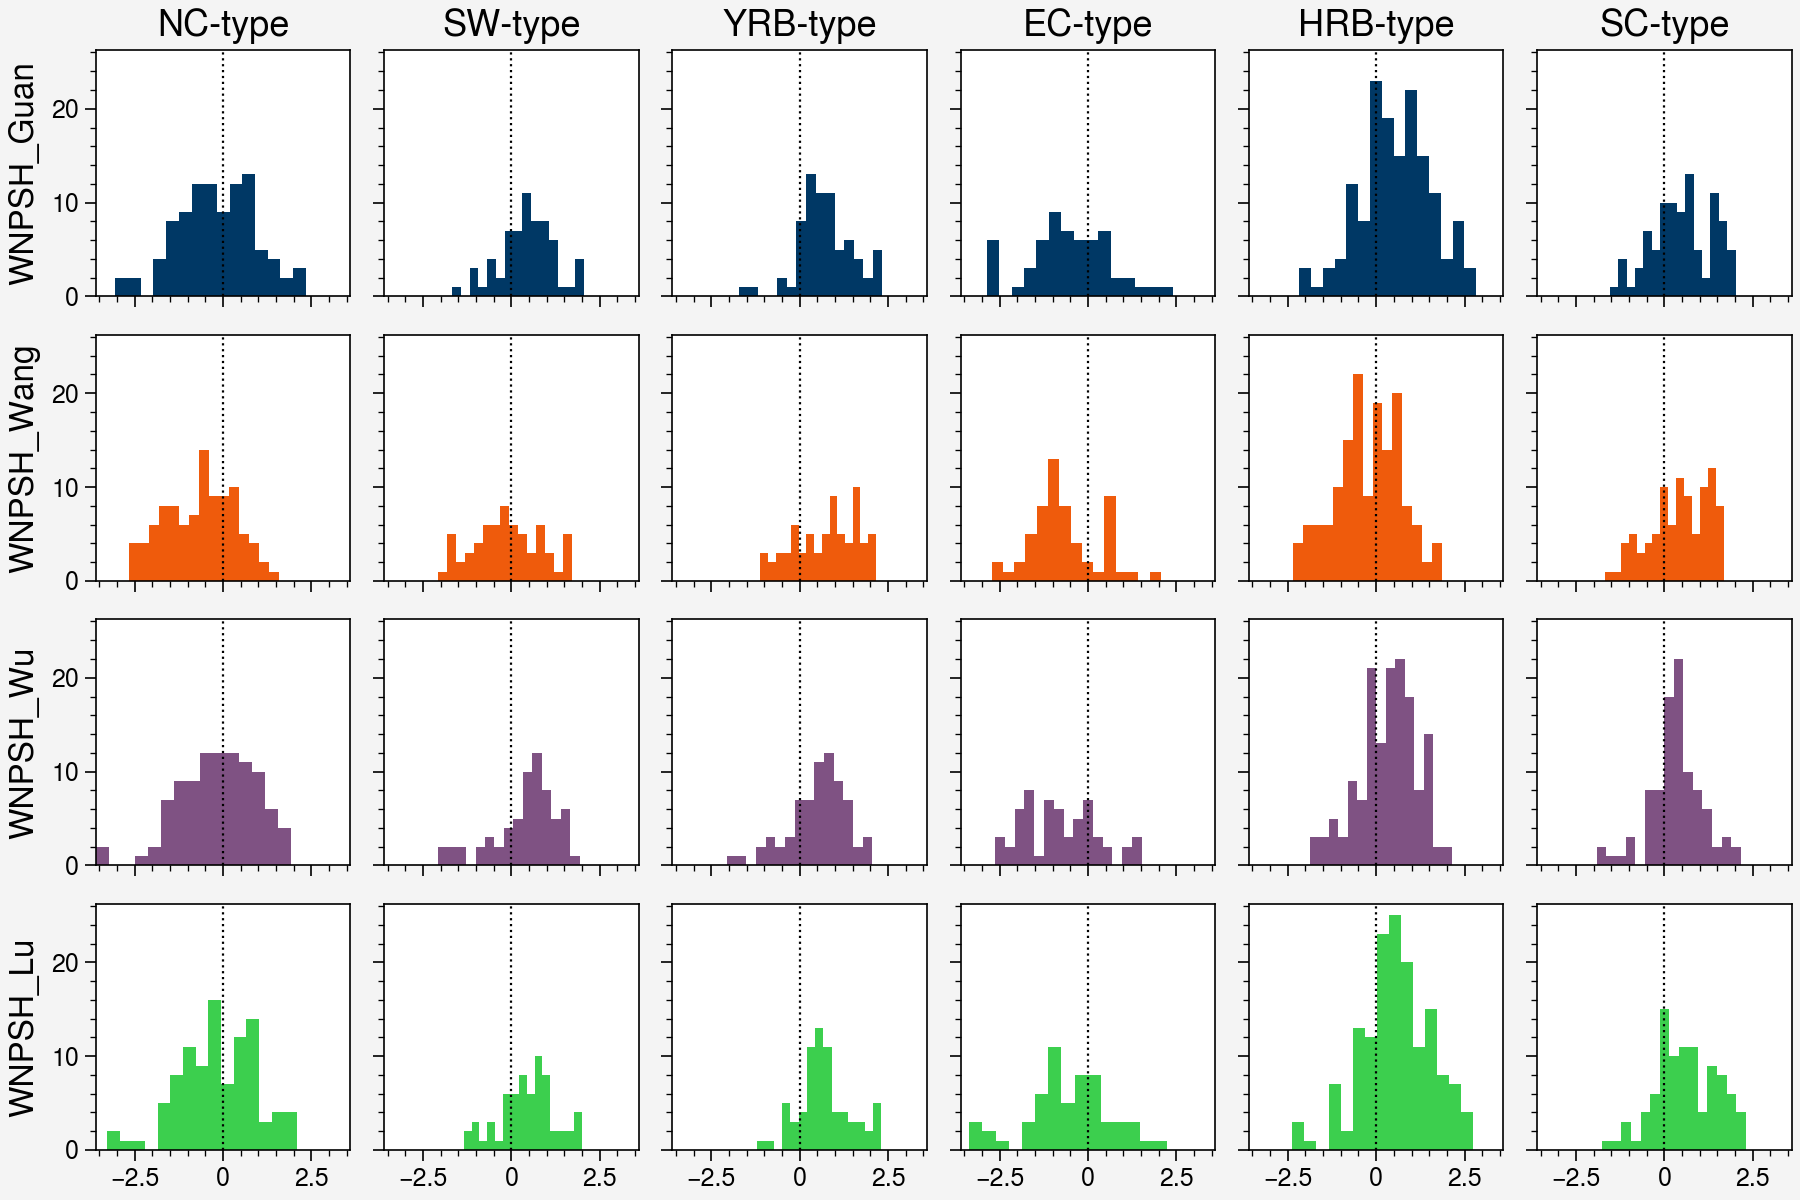

In [250]:
fig, ax = plt.subplots(4, 6, sharex=True, sharey=True, figsize=(9,6), gridspec_kw={'width_ratios': [1,1,1,1,1,1],'wspace': 0.001},constrained_layout=True)
wnpsh_index_prec['winner'] = winner
patterns = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']
cmap  = ['#003865','#EF5B0C','#7F5283','#3CCF4E']
for i in range(6):
    ax[0,i].hist(wnpsh_index_prec[wnpsh_index_prec['winner'] == i]['WNPSH_Guan'],bins=15,color=cmap[0],alpha=1)
    ax[1,i].hist(wnpsh_index_prec[wnpsh_index_prec['winner'] == i]['WNPSH_Wang'],bins=15,color=cmap[1],alpha=1)
    ax[2,i].hist(wnpsh_index_prec[wnpsh_index_prec['winner'] == i]['WNPSH_Wu'],bins=15,color=cmap[2],alpha=1)
    ax[3,i].hist(wnpsh_index_prec[wnpsh_index_prec['winner'] == i]['WNPSH_Lu'],bins=15,color=cmap[3],alpha=1)
    ax[0,i].set(xlim=(-3.6,3.6))
    ax[1,i].set(xlim=(-3.6,3.6))
    ax[2,i].set(xlim=(-3.6,3.6))
    ax[3,i].set(xlim=(-3.6,3.6))
    ax[0,i].axvline(x=0, linestyle=':', color = 'black', linewidth = 0.8)
    ax[1,i].axvline(x=0, linestyle=':', color = 'black', linewidth = 0.8)
    ax[2,i].axvline(x=0, linestyle=':', color = 'black', linewidth = 0.8)
    ax[3,i].axvline(x=0, linestyle=':', color = 'black', linewidth = 0.8)
    ax[0,i].grid(False)
    ax[1,i].grid(False)
    ax[2,i].grid(False)
    ax[3,i].grid(False)
    ax[0,i].set_title(patterns[i],fontsize=13)
ax[0,0].set_ylabel('WNPSH_Guan',fontsize=12)
ax[1,0].set_ylabel('WNPSH_Wang',fontsize=12)
ax[2,0].set_ylabel('WNPSH_Wu',fontsize=12)
ax[3,0].set_ylabel('WNPSH_Lu',fontsize=12)

plt.savefig("figure/compare_WNPSH_for_subregions.pdf")

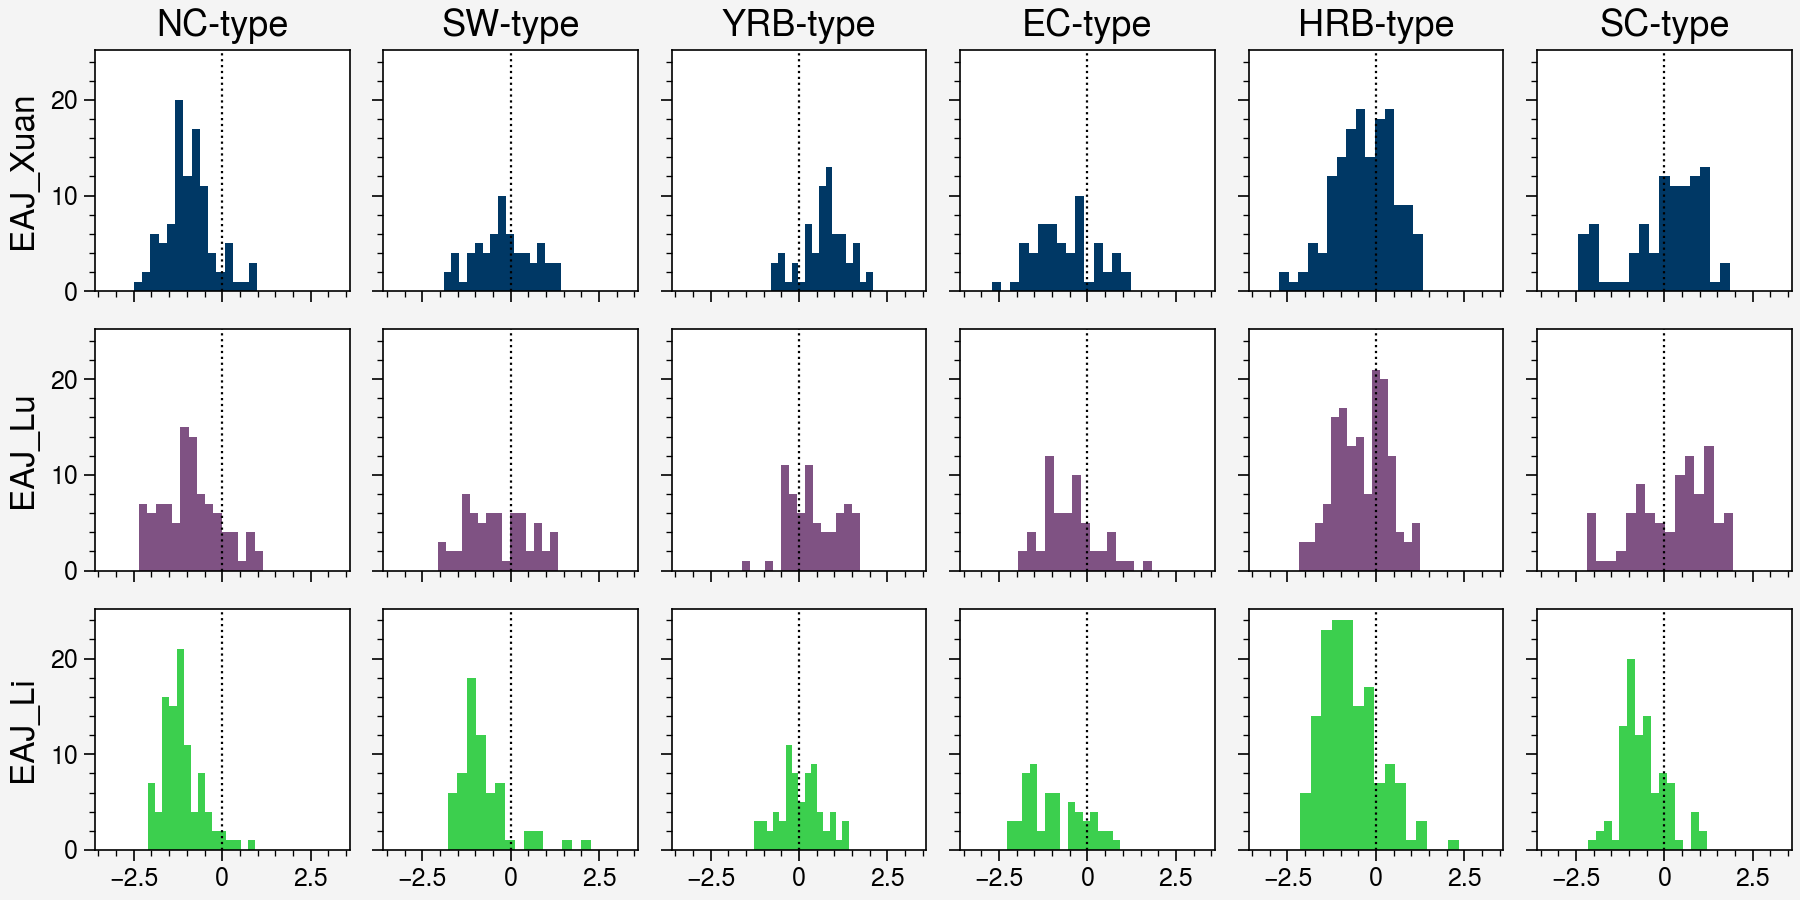

In [200]:
fig, ax = plt.subplots(3, 6, sharex=True, sharey=True, figsize=(9,4.5), gridspec_kw={'width_ratios': [1,1,1,1,1,1],'wspace': 0.001},constrained_layout=True)
eaj_index_prec['winner'] = winner
patterns = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']
cmap  = ['#003865','#7F5283','#3CCF4E']
for i in range(6):
    ax[0,i].hist(eaj_index_prec[eaj_index_prec['winner'] == i]['EAJ_Xuan'],bins=15,color=cmap[0],alpha=1)
    ax[1,i].hist(eaj_index_prec[eaj_index_prec['winner'] == i]['EAJ_Lu'],bins=15,color=cmap[1],alpha=1)
    ax[2,i].hist(eaj_index_prec[eaj_index_prec['winner'] == i]['EAJ_Li'],bins=15,color=cmap[2],alpha=1)
    ax[0,i].set(xlim=(-3.6,3.6))
    ax[1,i].set(xlim=(-3.6,3.6))
    ax[2,i].set(xlim=(-3.6,3.6))
    ax[0,i].axvline(x=0, linestyle=':', color = 'black', linewidth = 0.8)
    ax[1,i].axvline(x=0, linestyle=':', color = 'black', linewidth = 0.8)
    ax[2,i].axvline(x=0, linestyle=':', color = 'black', linewidth = 0.8)
    ax[0,i].grid(False)
    ax[1,i].grid(False)
    ax[2,i].grid(False)
    ax[0,i].set_title(patterns[i],fontsize=13)
ax[0,0].set_ylabel('EAJ_Xuan',fontsize=12)
ax[1,0].set_ylabel('EAJ_Lu',fontsize=12)
ax[2,0].set_ylabel('EAJ_Li',fontsize=12)

plt.savefig("figure/compare_EAJ_for_subregions.pdf")

# Plot

In [22]:
from matplotlib.patches import Ellipse

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]


In [246]:
wnpsh_index = pd.read_csv('output/subseasonal_wnpsh_index_Lu_zonal.csv',index_col=0)
wnpsh_index = wnpsh_index.rename(columns={'0':'wnpsh'})
wnpsh_index['wnpsh'] = (wnpsh_index['wnpsh'] - wnpsh_index['wnpsh'].mean()) / wnpsh_index['wnpsh'].std()

eaj_index = pd.read_csv('output/subseasonal_eaj_index_Xuan.csv',index_col=0)
eaj_index = eaj_index.rename(columns={'0':'eaj'})
eaj_index['eaj'] = (eaj_index['eaj'] - eaj_index['eaj'].mean()) / eaj_index['eaj'].std()

In [247]:
winner_obs = pd.read_csv('output/winner_obs.csv',index_col=0)
winner = pd.Series(winner_obs['0'])
winner.name = 'SOM_pattern'

In [248]:
winner = pd.DataFrame(winner)
winner['date'] = winner.index
winner['water_year'] = winner['date'].apply(lambda x: int(x[:4]))
winner = winner.rename(columns={0:'SOM_pattern'})
winner['wnpsh'] = winner['date'].apply(lambda x: wnpsh_index.loc[x])
winner['eaj'] = winner['date'].apply(lambda x: eaj_index.loc[x])

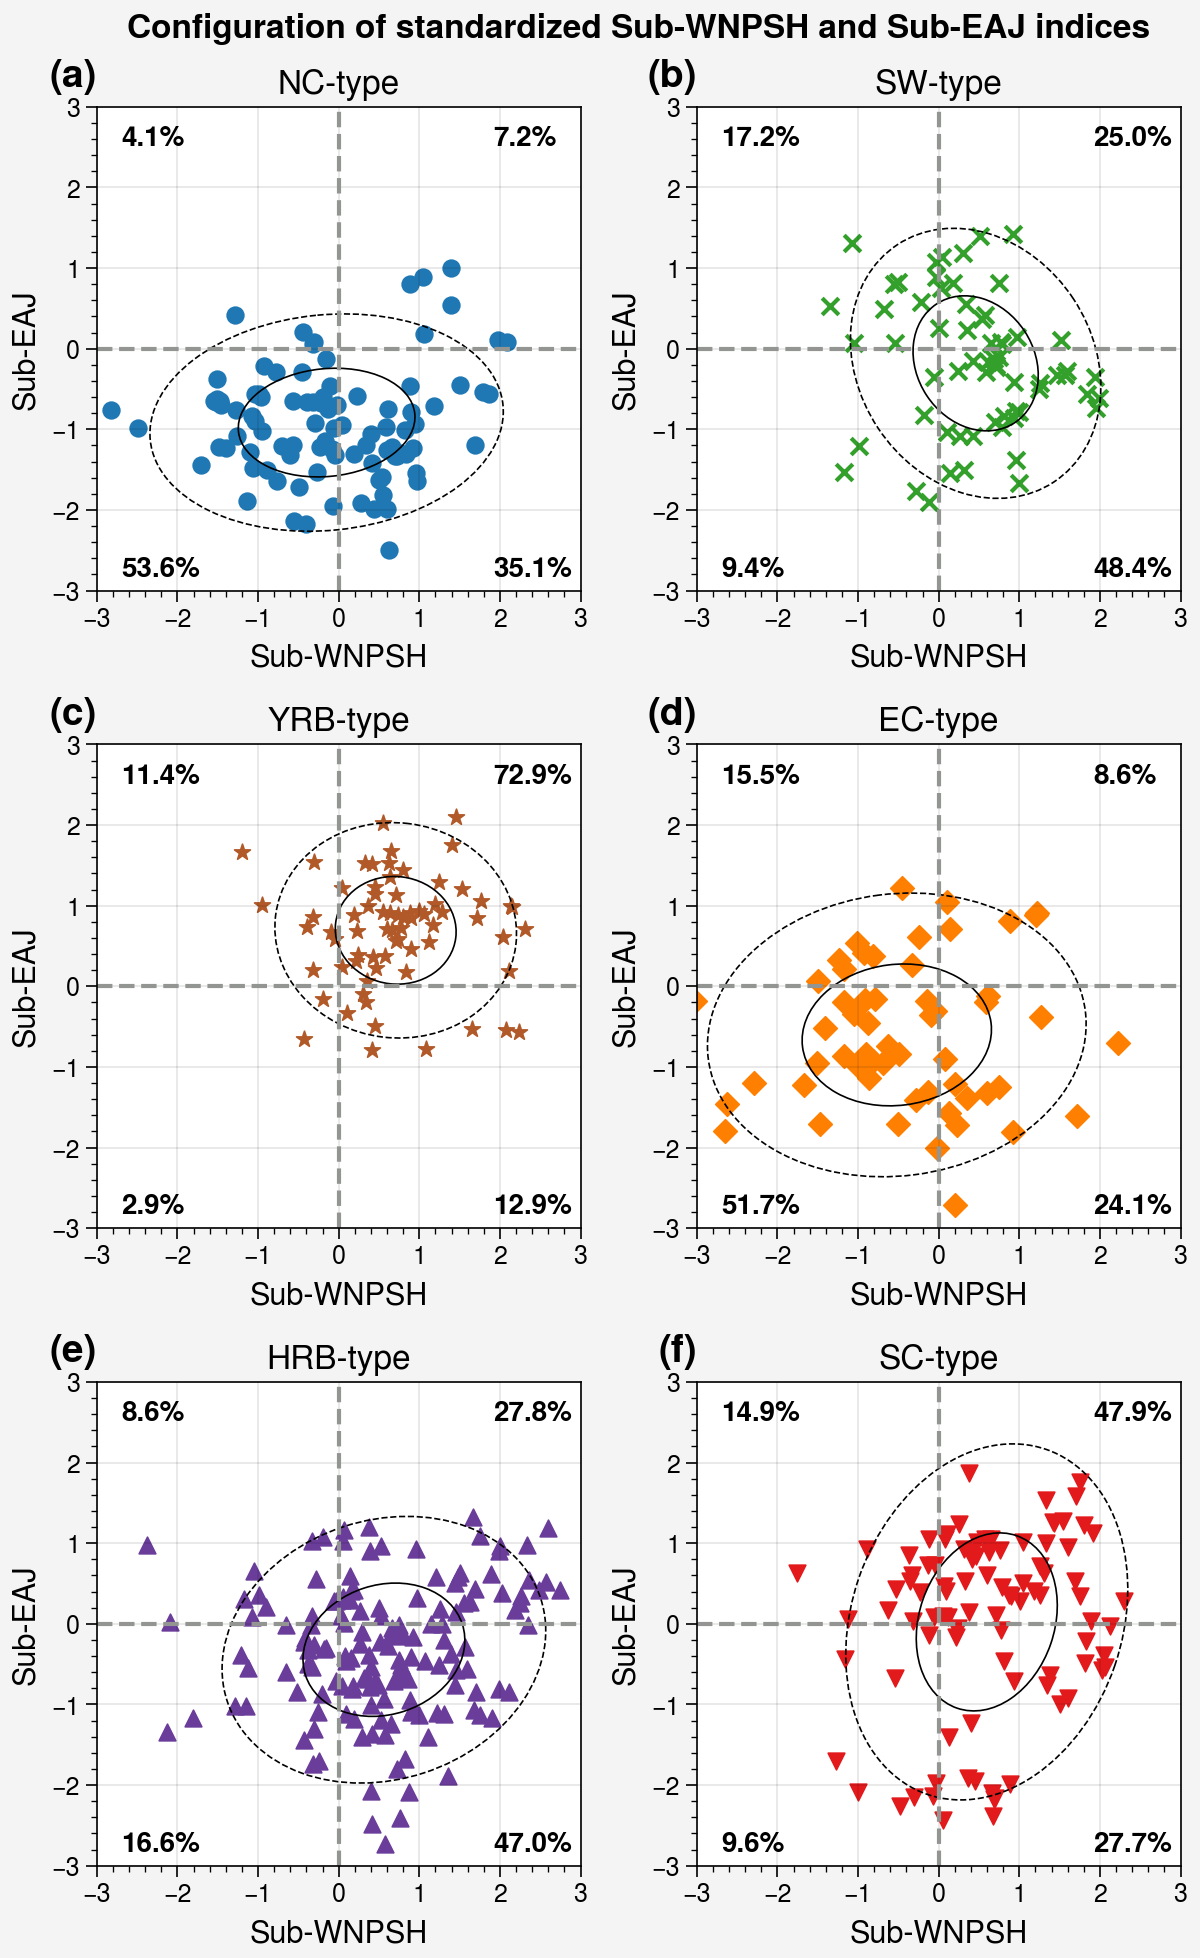

In [249]:
fig, ax = pplt.subplots(ncols=2,nrows=3,width = 6,share=False)
colors0 = ['red','blue','#E040FB','green','purple','pink']
markers=['o', 'x','*','D','^','v']
types = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']
# cmap = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
cmap = ['#1f78b4','#33a02c','#b15928','#ff7f00','#6a3d9a','#e31a1c']

def add_panel_label(ax, label, x = 0, y = 1.1):
    ax.text(x, y, label, transform=ax.transAxes,
        fontsize=14, fontweight='bold', va='top', ha='right')

for i in range(6):
    data = winner[winner['SOM_pattern']==i]
    ax[i].scatter(x=data['wnpsh'],y=data['eaj'],alpha=1,color=cmap[i],marker=markers[i])
    ax[i].format(xlim=(-3,3),ylim=[-3,3])
    ax[i].axvline(x=0, color='gray', ls='--')
    ax[i].axhline(y=0, color='gray', ls='--')

    # percent
    coord1_percent = sum((data['wnpsh']>0) & (data['eaj']>0)) / len(data) 
    coord2_percent = sum((data['wnpsh']<0) & (data['eaj']>0)) / len(data) 
    coord3_percent = sum((data['wnpsh']<0) & (data['eaj']<0)) / len(data) 
    coord4_percent = sum((data['wnpsh']>0) & (data['eaj']<0)) / len(data)
    coord1_percent = "{0:.1%}".format(coord1_percent)
    coord2_percent = "{0:.1%}".format(coord2_percent)
    coord3_percent = "{0:.1%}".format(coord3_percent)
    coord4_percent = "{0:.1%}".format(coord4_percent)
    ax[i].text(0.82,0.92,coord1_percent,fontdict={'fontsize':10,'weight':'bold'}, transform=ax[i].transAxes)
    ax[i].text(0.05,0.92,coord2_percent,fontdict={'fontsize':10,'weight':'bold'}, transform=ax[i].transAxes)
    ax[i].text(0.05,0.03,coord3_percent,fontdict={'fontsize':10,'weight':'bold'}, transform=ax[i].transAxes)
    ax[i].text(0.82,0.03,coord4_percent,fontdict={'fontsize':10,'weight':'bold'}, transform=ax[i].transAxes)

    add_panel_label(ax[i],'(' + list('abcdef')[i] + ')')
    ax[i].set_title(types[i],fontdict={'fontsize':12,'fontweight': 'medium'},y=1.08)
    ax[i].set_xlabel('Sub-WNPSH',fontsize=11)
    ax[i].set_ylabel('Sub-EAJ',fontsize=11)

    # draw one standard deviation ellipse
    cov = np.cov(data['wnpsh'],data['eaj'])
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    for nstd in range(1,3):
        w, h = 2 * nstd * np.sqrt(vals)

        ell = Ellipse(xy=(np.mean(data['wnpsh']), np.mean(data['eaj'])),
                    width=w, height=h,
                    angle=theta)
        ell.set_facecolor('none')
        # ell.set_edgecolor(colors0[i])
        ell.set_edgecolor('black')
        ell.set_linestyle(['-','--',][nstd-1])
        ax[i].add_artist(ell)

fig.suptitle('Configuration of standardized Sub-WNPSH and Sub-EAJ indices',y=1.1,fontsize=12)             
fig_dir = 'figure/'
fig.savefig(fig_dir + "WNPSH_EAJ_configuration_for_types2.pdf")